# Design the paired states with sequence symmetry, sampling backbones for MPNN while maintaining sequence realism

### Imports

In [7]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


### Design the paired states

In [2]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "08_design_paired_states"
design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/07_pair_bound_states/paired_states.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)

# two_state_design_paired_state should already work as-is for designing with an extra chain!
# it only designs the new peptide and the residues which differ between the two states, so the residues I've kept fixed throughout the design
# process should be excluded from the msd.
gen_array_tasks(
    distribute_func="crispy_shifty.protocols.msd.two_state_design_paired_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="6G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-2349 /home/broerman/crispy_shifty/projects/OPS/round_1/design/08_design_paired_states/run.sh


### Collect scorefiles of the designed paired states and concatenate

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "08_design_paired_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

100%|██████████| 4134/4134 [00:21<00:00, 193.06it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

In [9]:
# get the inputs of all the designs

import pyrosetta.distributed.cluster as cluster

for index in tqdm(scores_df.index):
    input_fname = cluster.get_scores_dict(index)["instance"]["tasks"]["pdb_path"]
    scores_df.loc[index, "input_fname"] = input_fname

100%|██████████| 4134/4134 [02:27<00:00, 28.04it/s]


In [14]:
# some failed design due to mishandling of cysteines
# get the unique inputs and generate a list of inputs not yet folded

unique_inputs = set(scores_df["input_fname"].values)

design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/07_pair_bound_states/paired_states.list"

not_designed = []
with open(design_list_file, 'r') as input_file:
    for line in input_file:
        if line.rstrip('\n') not in unique_inputs:
            not_designed.append(line)

with open("/home/broerman/crispy_shifty/projects/OPS/round_1/design/08_design_paired_states/not_yet_designed.list", 'w') as not_designed_file:
    not_designed_file.writelines(not_designed)

In [1]:
# design them, fixing the disulfides

sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "08_design_paired_states"
design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/08_design_paired_states/not_yet_designed.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)
extra_kwargs = {
    "skip_resi_subtype_check": "true"
}

# two_state_design_paired_state should already work as-is for designing with an extra chain!
# it only designs the new peptide and the residues which differ between the two states, so the residues I've kept fixed throughout the design
# process should be excluded from the msd.
gen_array_tasks(
    distribute_func="crispy_shifty.protocols.msd.two_state_design_paired_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="8G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-282 /home/broerman/crispy_shifty/projects/OPS/round_1/design/08_design_paired_states/run.sh


### Collect scorefiles of the designed paired states and concatenate

In [4]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "08_design_paired_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [5]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/4698 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [8]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [9]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))

4698


In [10]:
print(list(scores_df.columns))

['bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fixed_resis', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'repeat_len', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score', 'score_per_res', 'score_per_res_parent', 'score_per_res_x', 'seed', 'shift', 'ss_sc', 'state', 'time', 'tol', 'topo', 'total_length', 'total_score', 'trim_n

In [11]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Filter extreme outliers and change some dtypes

In [13]:
scores_df["score_per_res"] = scores_df["score_per_res"].astype(float)
scores_df["score_per_res_x"] = scores_df["score_per_res_x"].astype(float)
scores_df["ss_sc"] = scores_df["ss_sc"].astype(float)
scores_df["time"] = scores_df["time"].astype(float)

# query = "score_per_res < 0"
# sample_df = scores_df.query(query)
sample_df = scores_df

### Check delta `score_per_res` from X to parental sequence

In [14]:
sample_df["delta_score_per_res_x"] = (
    sample_df["score_per_res_x"] - sample_df["score_per_res_parent"]
)

### Plot Rosetta scores

5it [00:00, 35.27it/s]


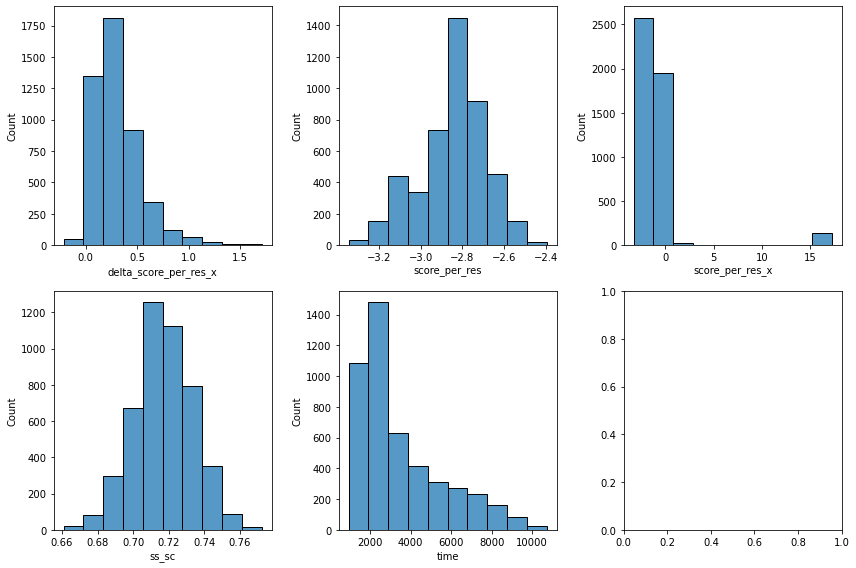

In [16]:
cols = [
    "delta_score_per_res_x",
    "score_per_res",
    "score_per_res_x",
    "ss_sc",
    "time",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    # hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "rosetta_scores.png"))

5it [00:00, 22.63it/s]


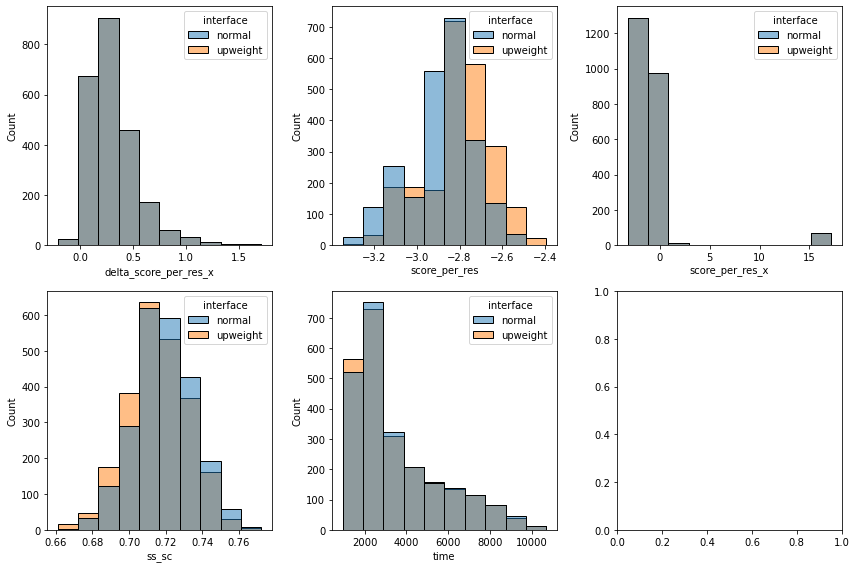

In [17]:
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="interface",
)

<Figure size 1440x1440 with 0 Axes>

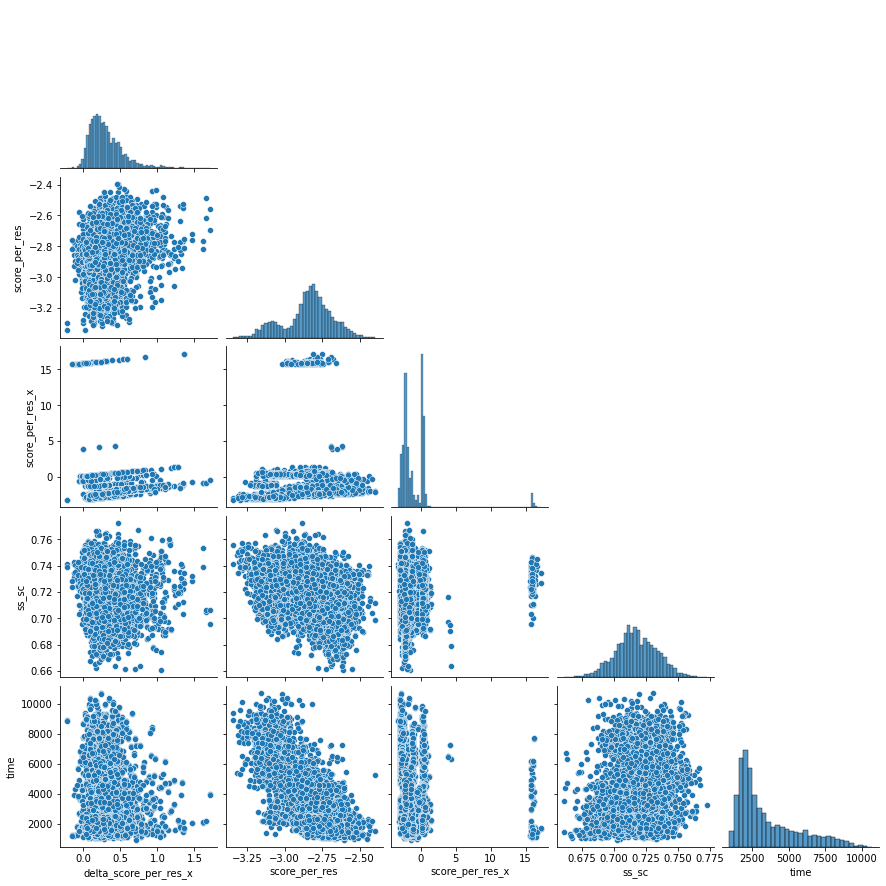

In [18]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    # hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "rosetta_scores_paired.png"))

<Figure size 1440x1440 with 0 Axes>

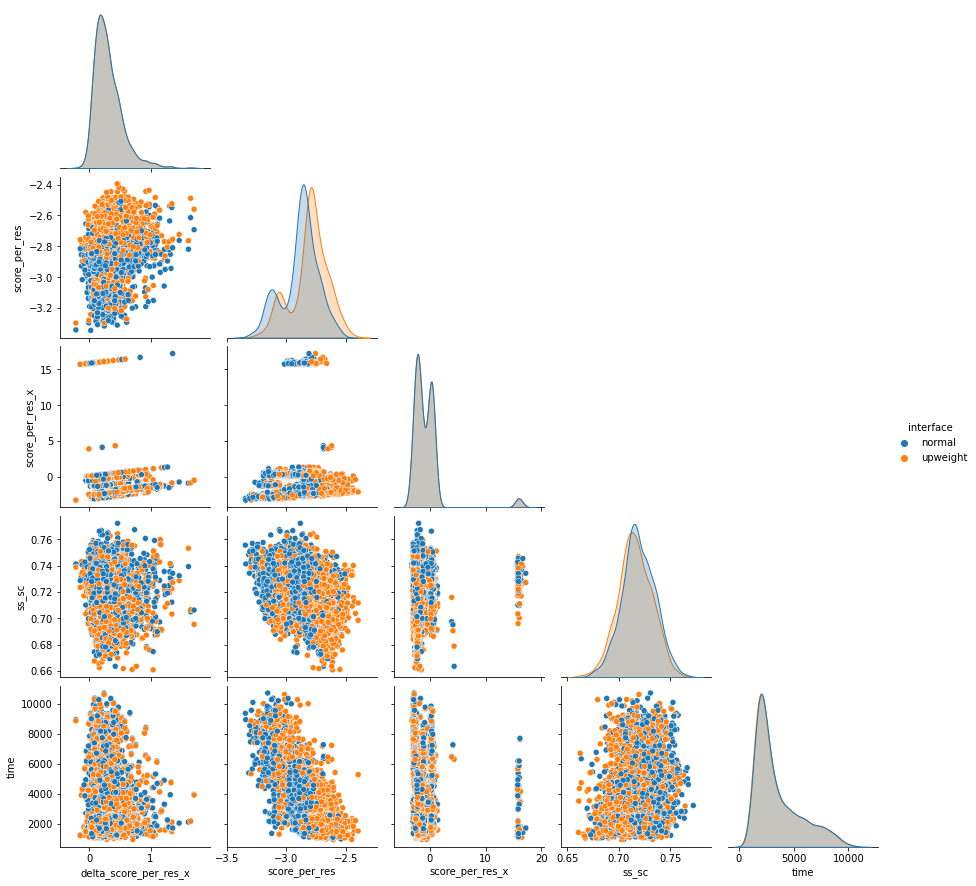

In [19]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="interface",
)

<Figure size 1440x1440 with 0 Axes>

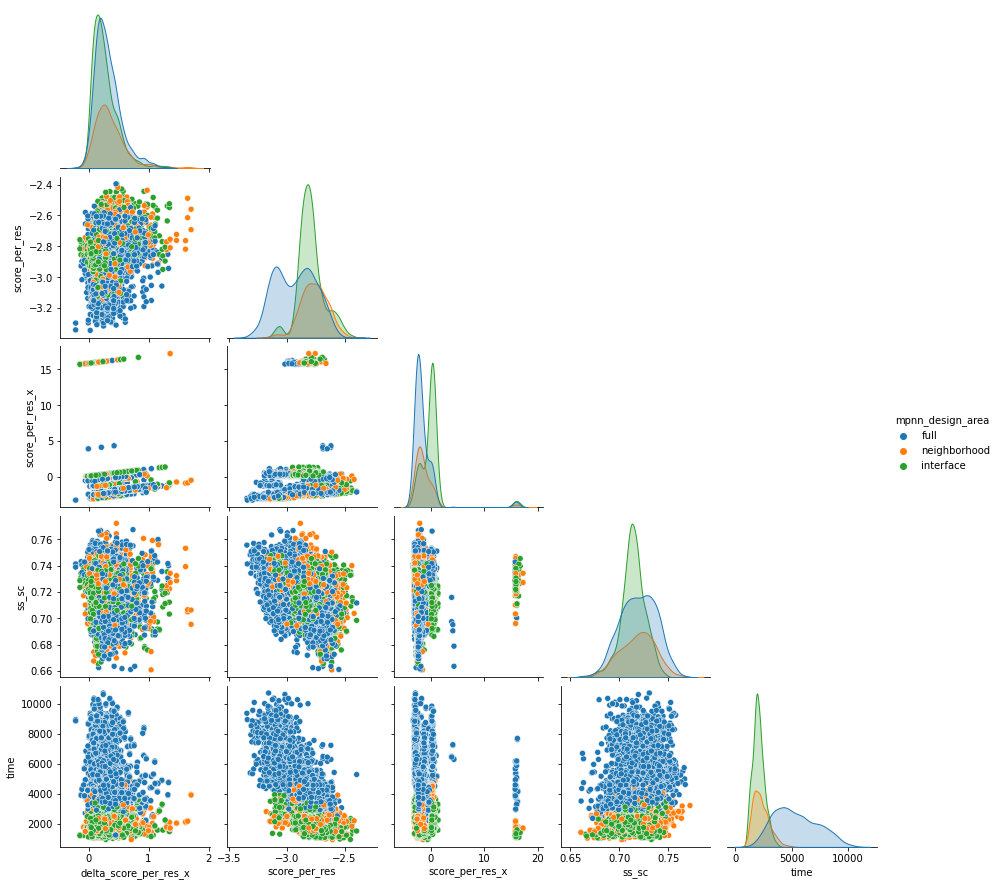

In [20]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="mpnn_design_area",
)

In [21]:
sample_df.parent.nunique()

24

### Filter out obviously bad decoys

In [32]:
query = "score_per_res < -2.5 and delta_score_per_res_x < 0.75 and ss_sc > 0.7"
filtered = sample_df.query(query)
len(filtered)

3855

In [33]:
filtered.parent.nunique()

24

In [35]:
set([v for v in scores_df.parent.values]) - set(
    [v for v in filtered.parent.values]
)

set()

### Save a list of outputs

In [36]:
simulation_name = "08_design_paired_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

with open(os.path.join(output_path, "designed_paired_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/3855 [00:00<?, ?it/s]